# Compare trained NPEs
In order to choose among the train NPEs, we'll use a KS test on the distribution of the percentile of $\theta_{\rm true}$ in ${\rm NPE}(\theta | x)$

In [1]:
import numpy as np 
from scipy import stats
from sedflow import obs as Obs
from sedflow import train as Train

In [2]:
from IPython.display import IFrame
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.use('PDF')
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
import torch
import torch.nn as nn 
import torch.nn.functional as F 
from sbi import utils as Ut
from sbi import inference as Inference

# Load test data

In [4]:
# x = theta_sps
# y = [u, g, r, i, z, sigma_u, sigma_g, sigma_r, sigma_i, sigma_z, z]
x_test, y_test = Train.load_data('test', version=1, sample='flow', params='thetas_unt')

In [5]:
x_test[:,6] = np.log10(x_test[:,6])
x_test[:,7] = np.log10(x_test[:,7])

# calculate KS test p-value for trained  `SEDflow` models

In [6]:
prior_low = [7, 0., 0., 0., 0., 1e-2, np.log10(4.5e-5), np.log10(4.5e-5), 0, 0., -2.]
prior_high = [12.5, 1., 1., 1., 1., 13.27, np.log10(1.5e-2), np.log10(1.5e-2), 3., 3., 1.]
lower_bounds = torch.tensor(prior_low)
upper_bounds = torch.tensor(prior_high)

prior = Ut.BoxUniform(low=lower_bounds, high=upper_bounds, device='cpu')

In [7]:
def pps(anpe_samples, ntest=100, nmcmc=10000): 
    ''' given npe, calculate pp for ntest test data
    '''
    pp_thetas, rank_thetas = [], [] 
    for igal in np.arange(ntest): 
        _mcmc_anpe = anpe_samples[igal]

        pp_theta, rank_theta = [], []
        for itheta in range(_mcmc_anpe.shape[1]): 
            pp_theta.append(stats.percentileofscore(_mcmc_anpe[:,itheta], x_test[igal,itheta])/100.)
            rank_theta.append(np.sum(np.array(_mcmc_anpe[:,itheta]) < x_test[igal,itheta]))
        pp_thetas.append(pp_theta)
        rank_thetas.append(rank_theta)

    pp_thetas = np.array(pp_thetas)
    rank_thetas = np.array(rank_thetas)
    return pp_thetas, rank_thetas

100x10.0 2.5475493301351623e-05


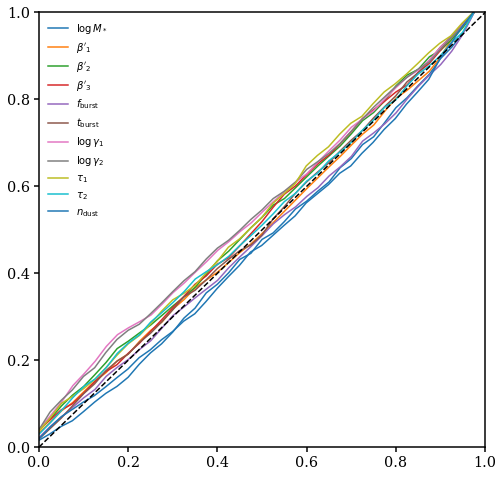

100x10.1 7.612495842769241e-06


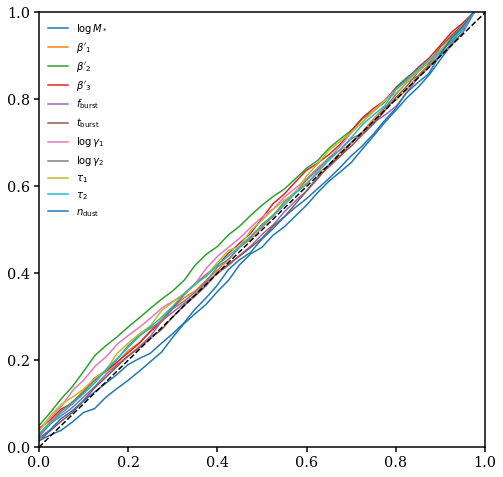

100x10.2 0.0003599072035143829


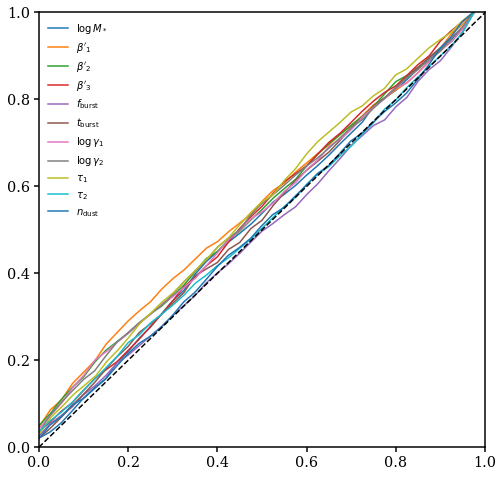

100x10.3 0.0007744075071918623


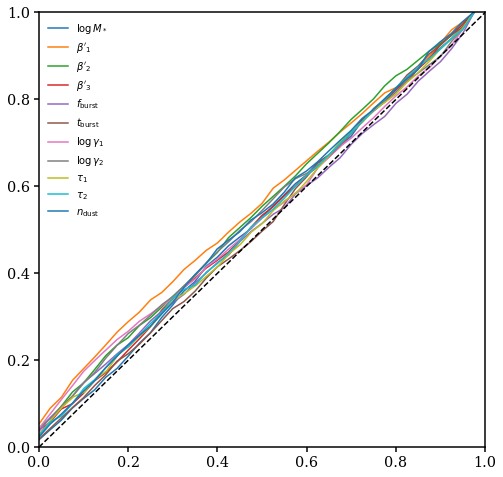

100x10.4 0.09538356667557879


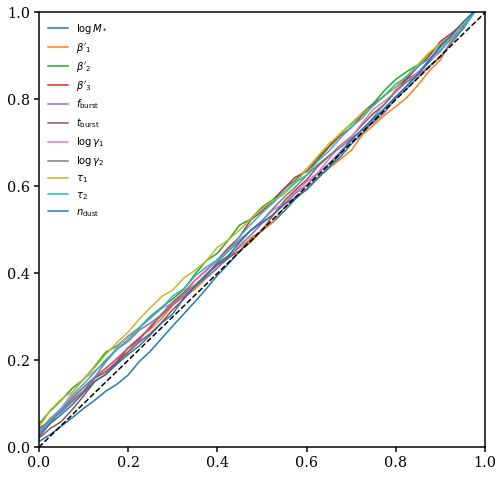

500x5.0 0.0048887638993819135


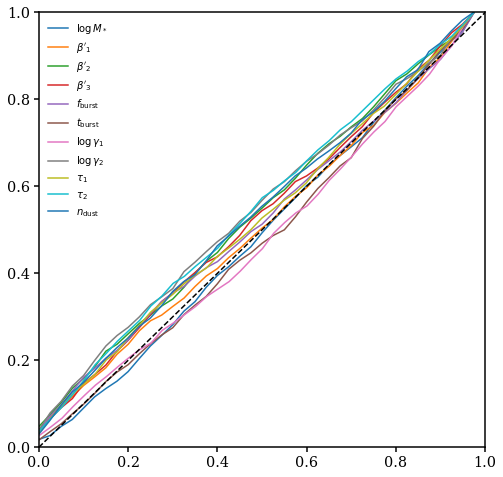

500x5.1 0.0005448425180077633


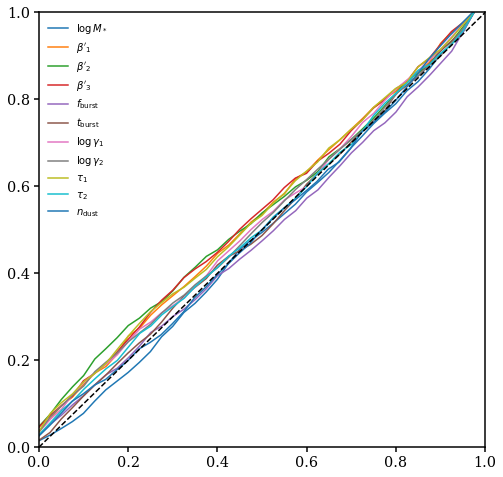

500x5.2 0.0018163110652043043


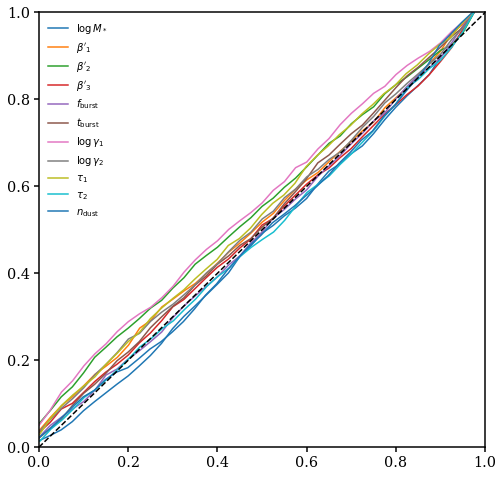

500x5.3 3.4738729895108453e-08


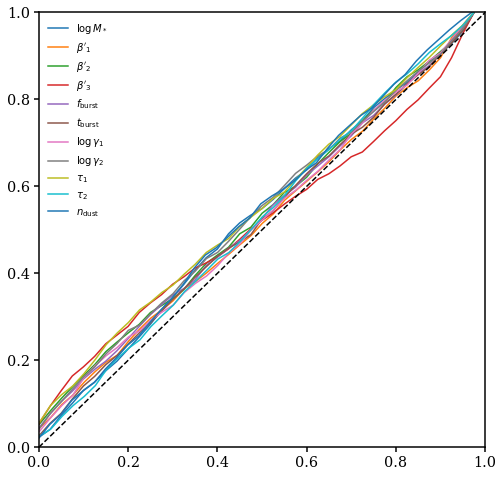

500x5.4 0.016277457435812326


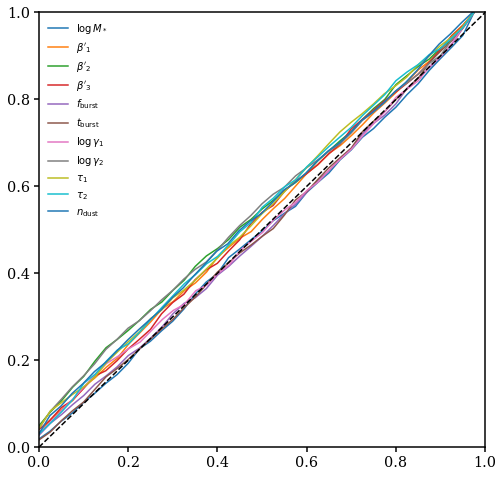

500x10.0 0.003049711680260655


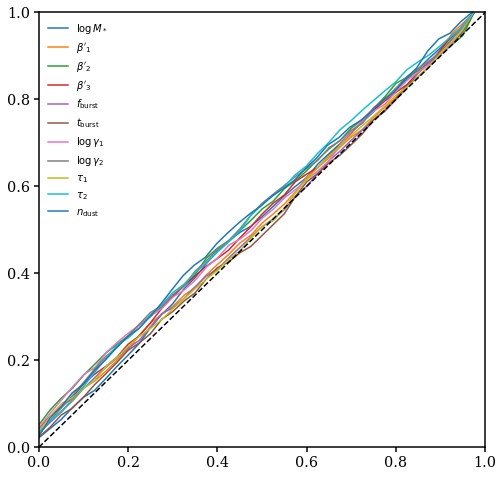

500x10.1 0.003616932381072741


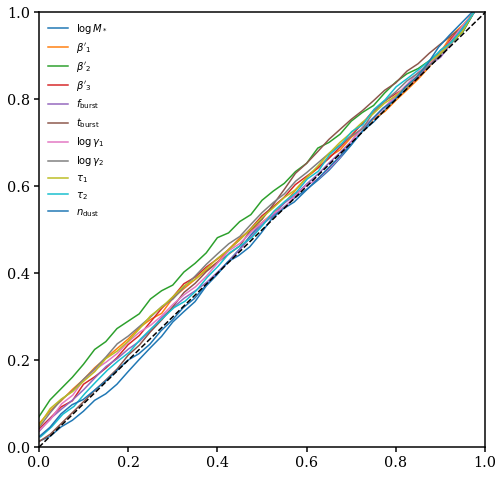

500x10.2 0.021286025502625625


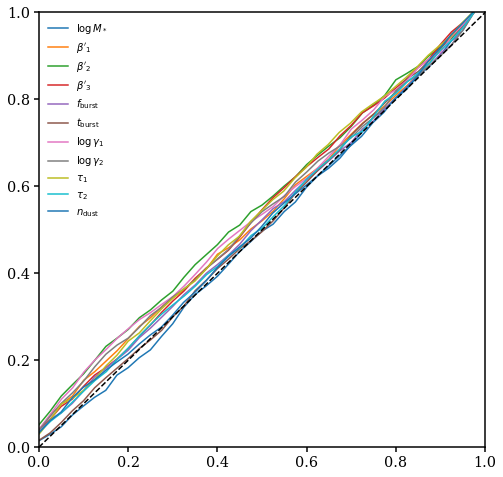

500x10.3 0.002601546739251733


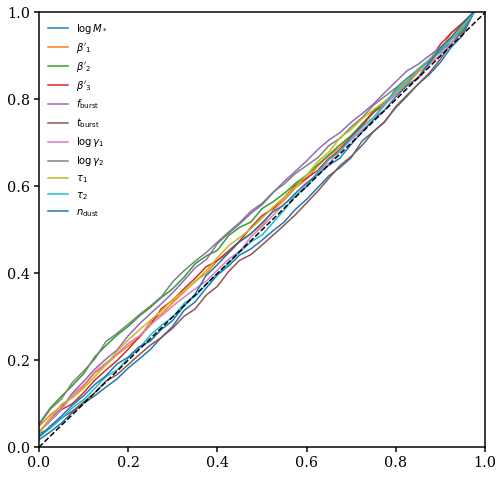

500x10.4 0.008902312488576553


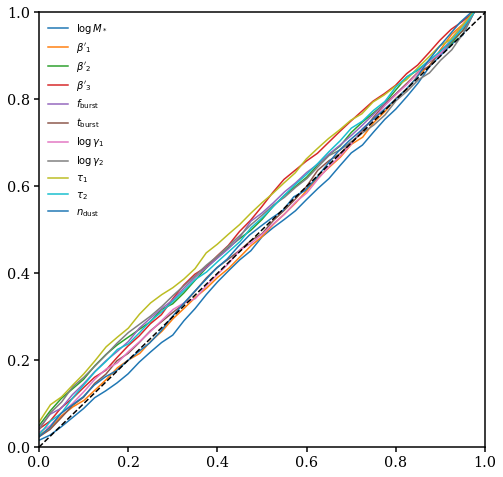

500x15.0 0.0005081642823094137


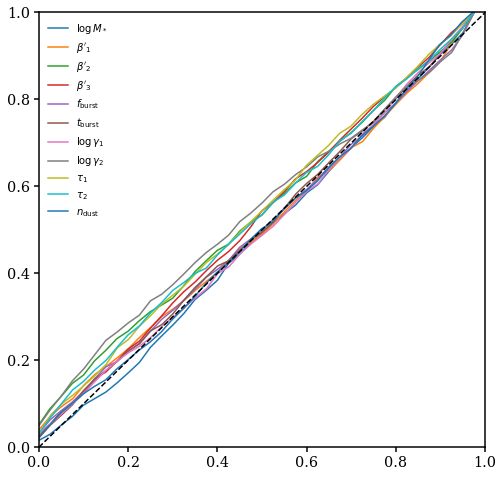

500x15.1 1.9553831256097655e-08


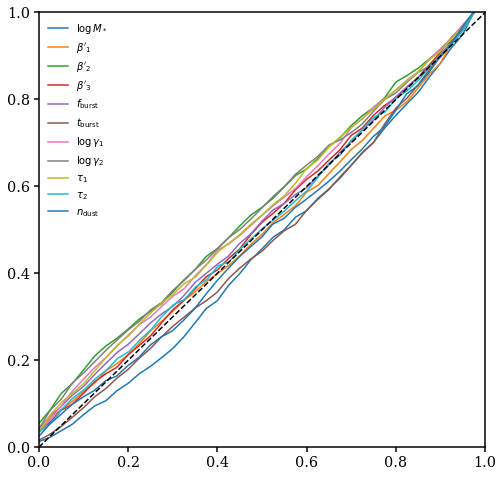

500x15.2 0.07323846263714673


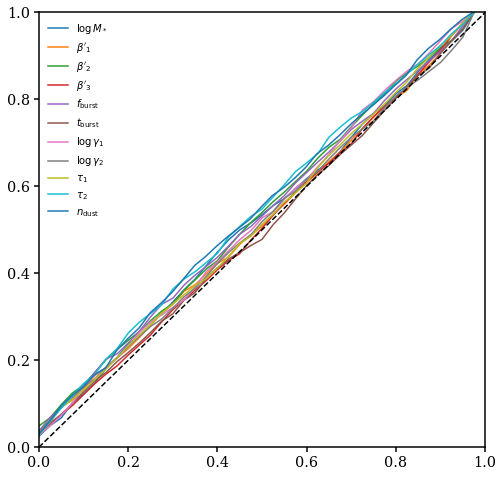

500x15.3 0.018740897631605264


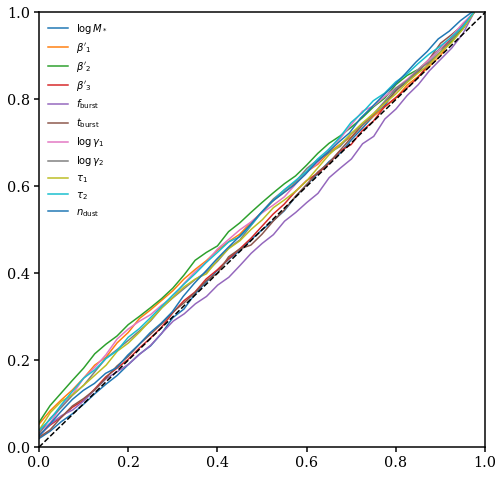

In [8]:
# architectures
archs = ['100x10.0', '100x10.1', '100x10.2', '100x10.3', '100x10.4', '500x5.0','500x5.1', '500x5.2', '500x5.3', '500x5.4', '500x10.0', '500x10.1', '500x10.2', '500x10.3', '500x10.4', '500x15.0', '500x15.1', '500x15.2', '500x15.3']
nhidden = [int(arch.split('x')[0]) for arch in archs]
nblocks = [int(arch.split('x')[1].split('.')[0]) for arch in archs]

ks_pvalues, ks_tot_pvalues = [], [] 
for i in range(len(archs)): 
    anpe_samples = np.load('/scratch/network/chhahn/sedflow/anpe_thetaunt_magsigz.toy.%s.samples.npy' % archs[i])
    
    _pp, _rank = pps(anpe_samples, ntest=1000, nmcmc=10000)
    
    ks_p = []
    for ii in range(_pp.shape[1]): 
        _, _ks_p = stats.kstest(_pp[ii], 'uniform')
        ks_p.append(_ks_p)
    ks_pvalues.append(np.array(ks_p))
    
    _, _ks_tot_p = stats.kstest(_pp.flatten(), 'uniform')
    ks_tot_pvalues.append(_ks_tot_p)
    print(archs[i], _ks_tot_p)
    
    theta_lbls = [r'$\log M_*$', r"$\beta'_1$", r"$\beta'_2$", r"$\beta'_3$", r'$f_{\rm burst}$', r'$t_{\rm burst}$', r'$\log \gamma_1$', r'$\log \gamma_2$', r'$\tau_1$', r'$\tau_2$', r'$n_{\rm dust}$']
    fig = plt.figure(figsize=(8,8))
    sub = fig.add_subplot(111)
    for itheta in range(_pp.shape[1]): 
        # evaluate the histogram
        values, base = np.histogram(_pp[:,itheta], bins=40)
        #evaluate the cumulative
        cumulative = np.cumsum(values) / np.sum(values)
        sub.plot(base[:-1], cumulative, label=theta_lbls[itheta])
    sub.plot([0., 1.], [0., 1.], c='k', ls='--')
    sub.set_xlim(0., 1.)
    sub.set_ylim(0., 1.)
    sub.legend(loc='upper left')
    plt.show()

In [9]:
for i in range(np.array(ks_pvalues).shape[1]): 
    print(archs[np.argmax(np.array(ks_pvalues)[:,i])])

500x15.2
500x10.4
100x10.2
500x5.3
500x15.1
500x15.0
500x5.2
500x5.0
500x10.3
500x10.2
500x10.4
